In [1]:
%cd '/Users/rattie/Dev/sdo_tracking_framework'
import os, glob
import time
import numpy as np
from scipy.io import readsav
import matplotlib.pyplot as plt
import fitsio
from astropy.io import fits
from scipy.ndimage.filters import gaussian_filter 
from scipy.signal import convolve2d
%matplotlib notebook

/Users/rattie/Dev/sdo_tracking_framework


In [2]:
def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson

def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return vx, vy

def load_vels_mean(v_files1, v_files2, trange):
    "Load two pairs of velocity components data, average them and output the averaged pairs of velocity components"
    vx1, vy1 = load_vel_mean(v_files1, trange)
    vx2, vy2 = load_vel_mean(v_files2, trange)
    return vx1, vy1, vx2, vy2

def smooth_vel(vxs, vys, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be: 
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm. 
     
     Returns the smoothed velocity components
    """ 
    
    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm])
        vxs2 = convolve2d(vxs, box, mode='same')
        vys2 = convolve2d(vys, box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(vxs, sigma=sigma, order=0)
        vys2 = gaussian_filter(vys, sigma=sigma, order=0)
        
    return vxs2, vys2


In [3]:
# Parent directories of the velocities
data_dir_stein = '/Users/rattie/Data/Ben/SteinSDO/'
data_dir_deepvel = '/Users/rattie/Data/Ben/SteinSDO/output_newDeepVel_without_edge_effect/' 
# output directory for the plots
plot_dir = '/Users/rattie/Data/Ben/SteinSDO/comparisons'
fwhm = 7
sigma = fwhm/2.35
# Select a subfield excluding edge effects
imsize = 263 # actual size is 264 but original size was 263 then padded to 264 to make it even for the Fourier transform
# Use same padding size as in Tremblay et al. 2018 used pad = 10
pad = 10
fov = np.s_[pad:imsize - pad, pad:imsize-pad]


# Calculate correlations with simulation

## DeepVel - simulation

In [4]:
# Simulation data
svx_files = sorted(glob.glob(os.path.join(data_dir_stein,'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(data_dir_stein,'SDO_vy*.fits')))
# Deepvel data
dvx_files = sorted(glob.glob(os.path.join(data_dir_deepvel, 'DeepVel_vx1_drift_*.fits')))
dvy_files = sorted(glob.glob(os.path.join(data_dir_deepvel, 'DeepVel_vy1_drift_*.fits')))


### Calculate correlation coefficients

In [5]:
# Sliding windows
start_frames = np.arange(0,50,5)
duration = 29
tranges = [[f, f+duration] for f in start_frames]
# Smoothing kernel 
kernel = 'boxcar'

<IPython.core.display.Javascript object>


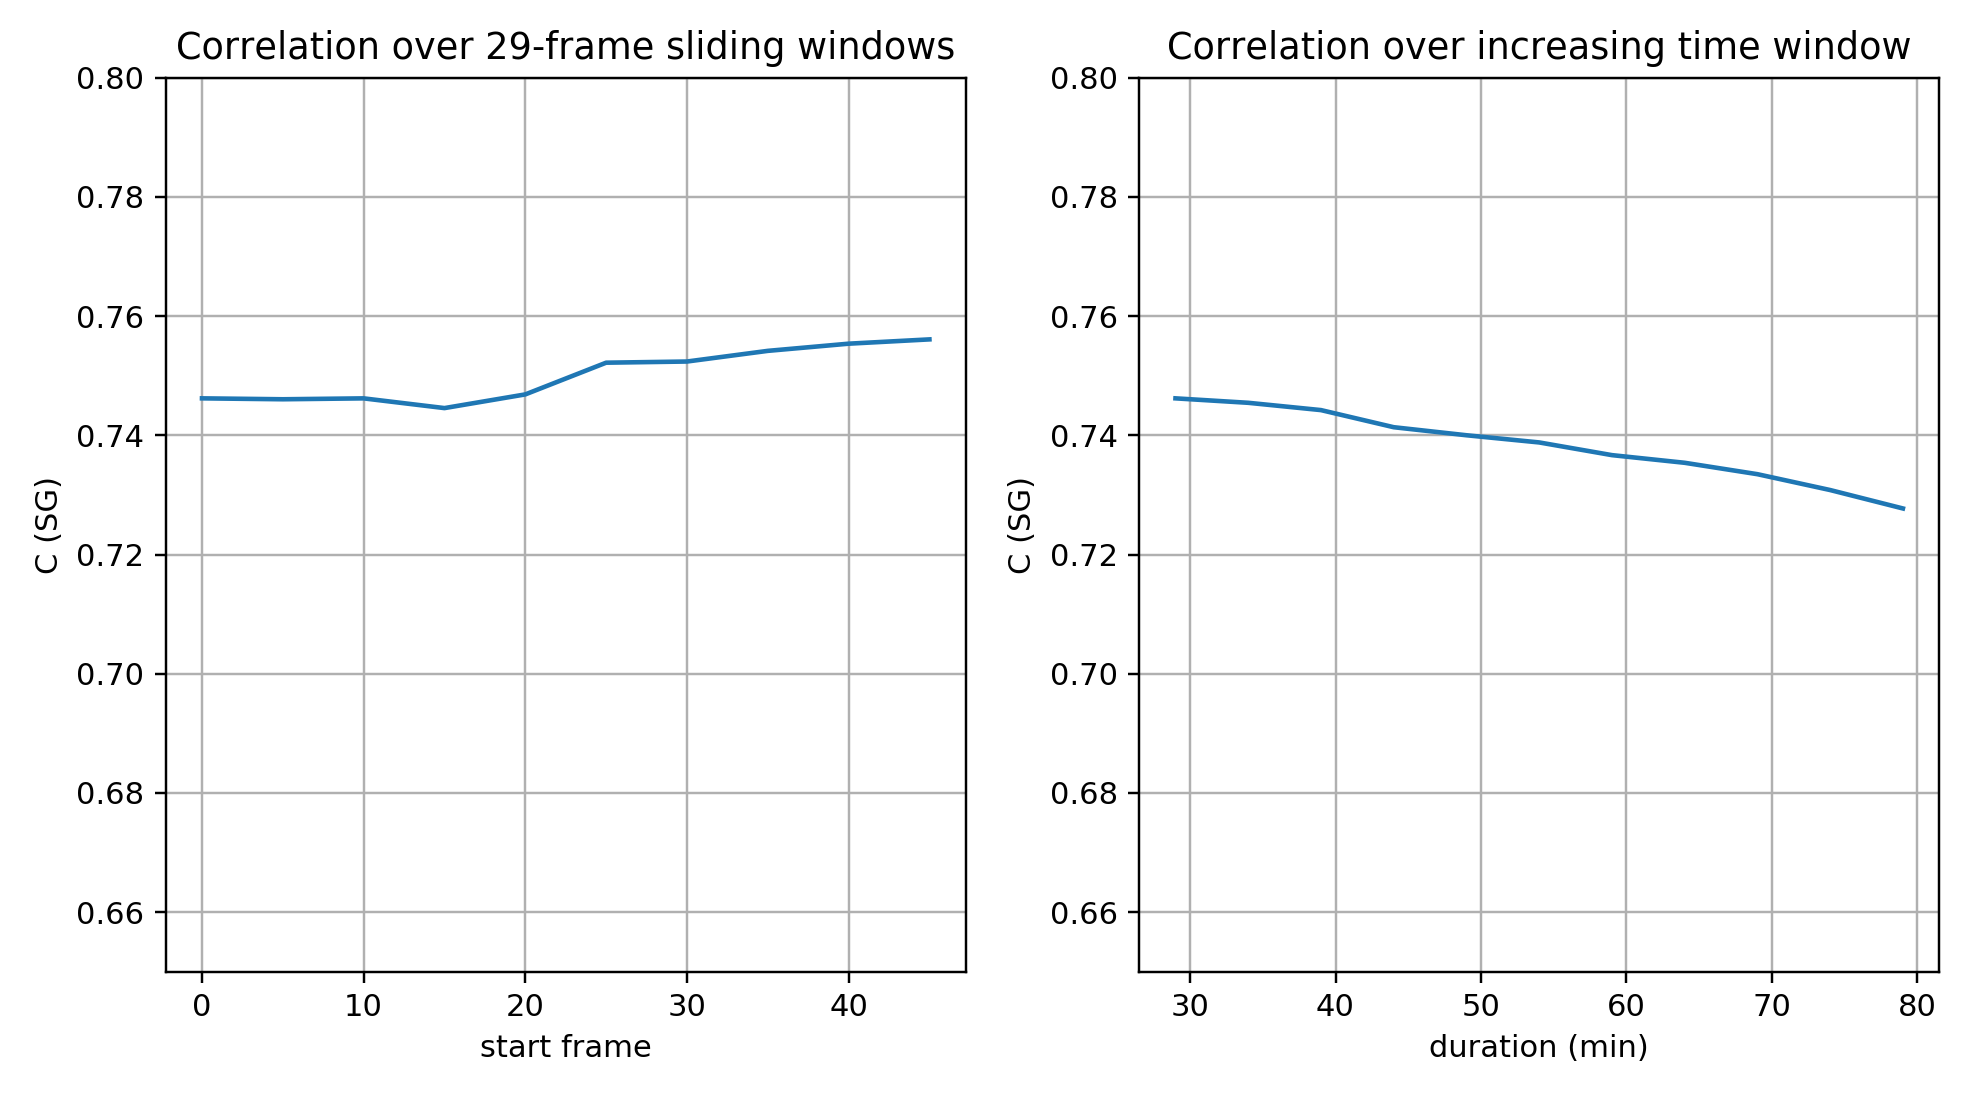

In [7]:
# Load both
vx_stein1, vy_stein1, vx_deepvel1, vy_deepvel1  = zip(*[load_vels_mean((svx_files, svy_files), (dvx_files, dvy_files), trange) for trange in tranges])
# smooth the Stein velocities 
vx_stein1, vy_stein1 = zip(*[smooth_vel(vx, vy, fwhm, kernel=kernel) for vx, vy in zip(vx_stein1, vy_stein1)])
# Smooth deepvel 
vx_deepvel1, vy_deepvel1 = zip(*[smooth_vel(vx, vy, fwhm, kernel=kernel) for vx, vy in zip(vx_deepvel1, vy_deepvel1)])
c_pearsons1 = [calc_c_pearson(vx_stein1[i], vx_deepvel1[i], vy_stein1[i], vy_deepvel1[i], fov=fov) for i in range(len(tranges))]

%matplotlib notebook
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.plot(start_frames, c_pearsons1)
plt.xlabel('start frame')
plt.ylabel('C (SG)')
plt.grid(True)
plt.title('Correlation over 29-frame sliding windows')
plt.ylim([0.65, 0.8])
plt.tight_layout()

# Over increasing time window size
twin = np.arange(29, 80, 5)
tranges2 = [[0, f] for f in twin]
# Load both
vx_stein2, vy_stein2, vx_deepvel2, vy_deepvel2  = zip(*[load_vels_mean((svx_files, svy_files), (dvx_files, dvy_files), trange) for trange in tranges2])
# smooth the Stein velocities 
vx_stein2, vy_stein2 = zip(*[smooth_vel(vx, vy, fwhm, kernel=kernel) for vx, vy in zip(vx_stein2, vy_stein2)])
# Smooth deepvel 
vx_deepvel2, vy_deepvel2 = zip(*[smooth_vel(vx, vy, fwhm, kernel=kernel) for vx, vy in zip(vx_deepvel2, vy_deepvel2)])
c_pearsons2 = [calc_c_pearson(vx_stein2[i], vx_deepvel2[i], vy_stein2[i], vy_deepvel2[i], fov=fov) for i in range(len(tranges2))]

plt.subplot(1,2,2)
plt.plot(twin, c_pearsons2)
plt.xlabel('duration (min)')
plt.ylabel('C (SG)')
plt.grid(True)
plt.title('Correlation over increasing time window')
plt.ylim([0.65, 0.8])
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'DeepVel_correlation_SG_scales.png'), dpi=120)


## Load Balltracking data

In [8]:
import balltracking.balltrack as blt

def mean_bt_velocity(ballpos_top, ballpos_bot, tranges, fwhm, a_top, a_bot, kernel):
    dims = [264, 264]
    fov = np.s_[0:263, 0:263]
    vxs_top, vys_top, _ = zip(*[blt.make_velocity_from_tracks(ballpos_top, dims, trange, fwhm, kernel=kernel) for trange in tranges])
    vxs_bot, vys_bot, _ = zip(*[blt.make_velocity_from_tracks(ballpos_bot, dims, trange, fwhm, kernel=kernel) for trange in tranges])
    vxs_top2 = [a_top * v[fov] for v in vxs_top]
    vys_top2 = [a_top * v[fov] for v in vys_top]
    vxs_bot2 = [a_bot * v[fov] for v in vxs_bot]
    vys_bot2 = [a_bot * v[fov] for v in vys_bot]

    vxs = [(vx_top + vx_bot)/2 for vx_top, vx_bot in zip(vxs_top2, vxs_bot2)]
    vys = [(vy_top + vy_bot)/2 for vy_top, vy_bot in zip(vys_top2, vys_bot2)]
    
    return vxs, vys, vxs_top2, vys_top2, vxs_bot2, vys_bot2

In [30]:
# Get balltracked, undrifted data, average flow at the different time slices
# directory for the drifting images that Balltracking need. 
fourier_radius = 3
sigma_factor = 1.5

bt_dir = '/Users/rattie/Data/Ben/SteinSDO/optimization_fourier_radius_3px_finer_grid/rs2.0_dp0.3_sigmaf{:1.2f}_intsteps5_nt80'.format(sigma_factor)
ballpos_top = np.load(os.path.join(bt_dir, 'ballpos_top.npy'))
ballpos_bot = np.load(os.path.join(bt_dir, 'ballpos_bottom.npy'))
# calibration coefficients
#cal_factors = np.load('/Users/rattie/Data/Ben/SteinSDO/optimization/cal_factors_sigma_factor1.20_{:s}.npy'.format(kernel))
cal_factor = np.load('/Users/rattie/Data/Ben/SteinSDO/optimization_fourier_radius_3px_finer_grid/cal_factor_sigma_factor{:1.2f}_{:s}.npy'.format(sigma_factor, kernel))

# a_top = cal_factors[0, fourier_radius]
# a_bot = cal_factors[1, fourier_radius]
a_top, a_bot = cal_factor
print('a_top: ', a_top)
print('a_bot: ', a_bot)

# Smoothing kernel 
kernel = 'boxcar'
fwhm = 7
# list of time averages
duration = 30
tranges = [[f, f+duration] for f in start_frames]
# Over increasing time window size
twin = np.arange(30, 80+5, 5)
tranges2 = [[0, f] for f in twin]

a_top:  1.390284774612481
a_bot:  1.287010123030736


In [31]:
# Average the balltrack velocities

# sliding window of fixed average time window
bvxs, bvys, vxs_top, vys_top, vxs_bot, vys_bot = mean_bt_velocity(ballpos_top, ballpos_bot, tranges, fwhm, a_top, a_bot, kernel)
# increasing average time window
bvxs2, bvys2, vxs_top2, vys_top2, vxs_bot2, vys_bot2 = mean_bt_velocity(ballpos_top, ballpos_bot, tranges2, fwhm, a_top, a_bot, kernel)


In [32]:
# Get correlations for the padding size set earlier (Tremblay et al. 2018 used pad = 10)

# over sliding window of fixed average time window
c_pearsons_b_top = [calc_c_pearson(vx_stein1[i], vxs_top[i], vy_stein1[i], vys_top[i], fov=fov) for i in range(len(tranges))]
c_pearsons_b_bot = [calc_c_pearson(vx_stein1[i], vxs_bot[i], vy_stein1[i], vys_bot[i], fov=fov) for i in range(len(tranges))]
c_pearsons_b = [calc_c_pearson(vx_stein1[i], bvxs[i], vy_stein1[i], bvys[i], fov=fov) for i in range(len(tranges))]
# over an increasing average time window
c_pearsons_b_top2 = [calc_c_pearson(vx_stein2[i], vxs_top2[i], vy_stein2[i], vys_top2[i], fov=fov) for i in range(len(tranges2))]
c_pearsons_b_bot2 = [calc_c_pearson(vx_stein2[i], vxs_bot2[i], vy_stein2[i], vys_bot2[i], fov=fov) for i in range(len(tranges2))]
c_pearsons_b2 = [calc_c_pearson(vx_stein2[i], bvxs2[i], vy_stein2[i], bvys2[i], fov=fov) for i in range(len(tranges2))]


<IPython.core.display.Javascript object>


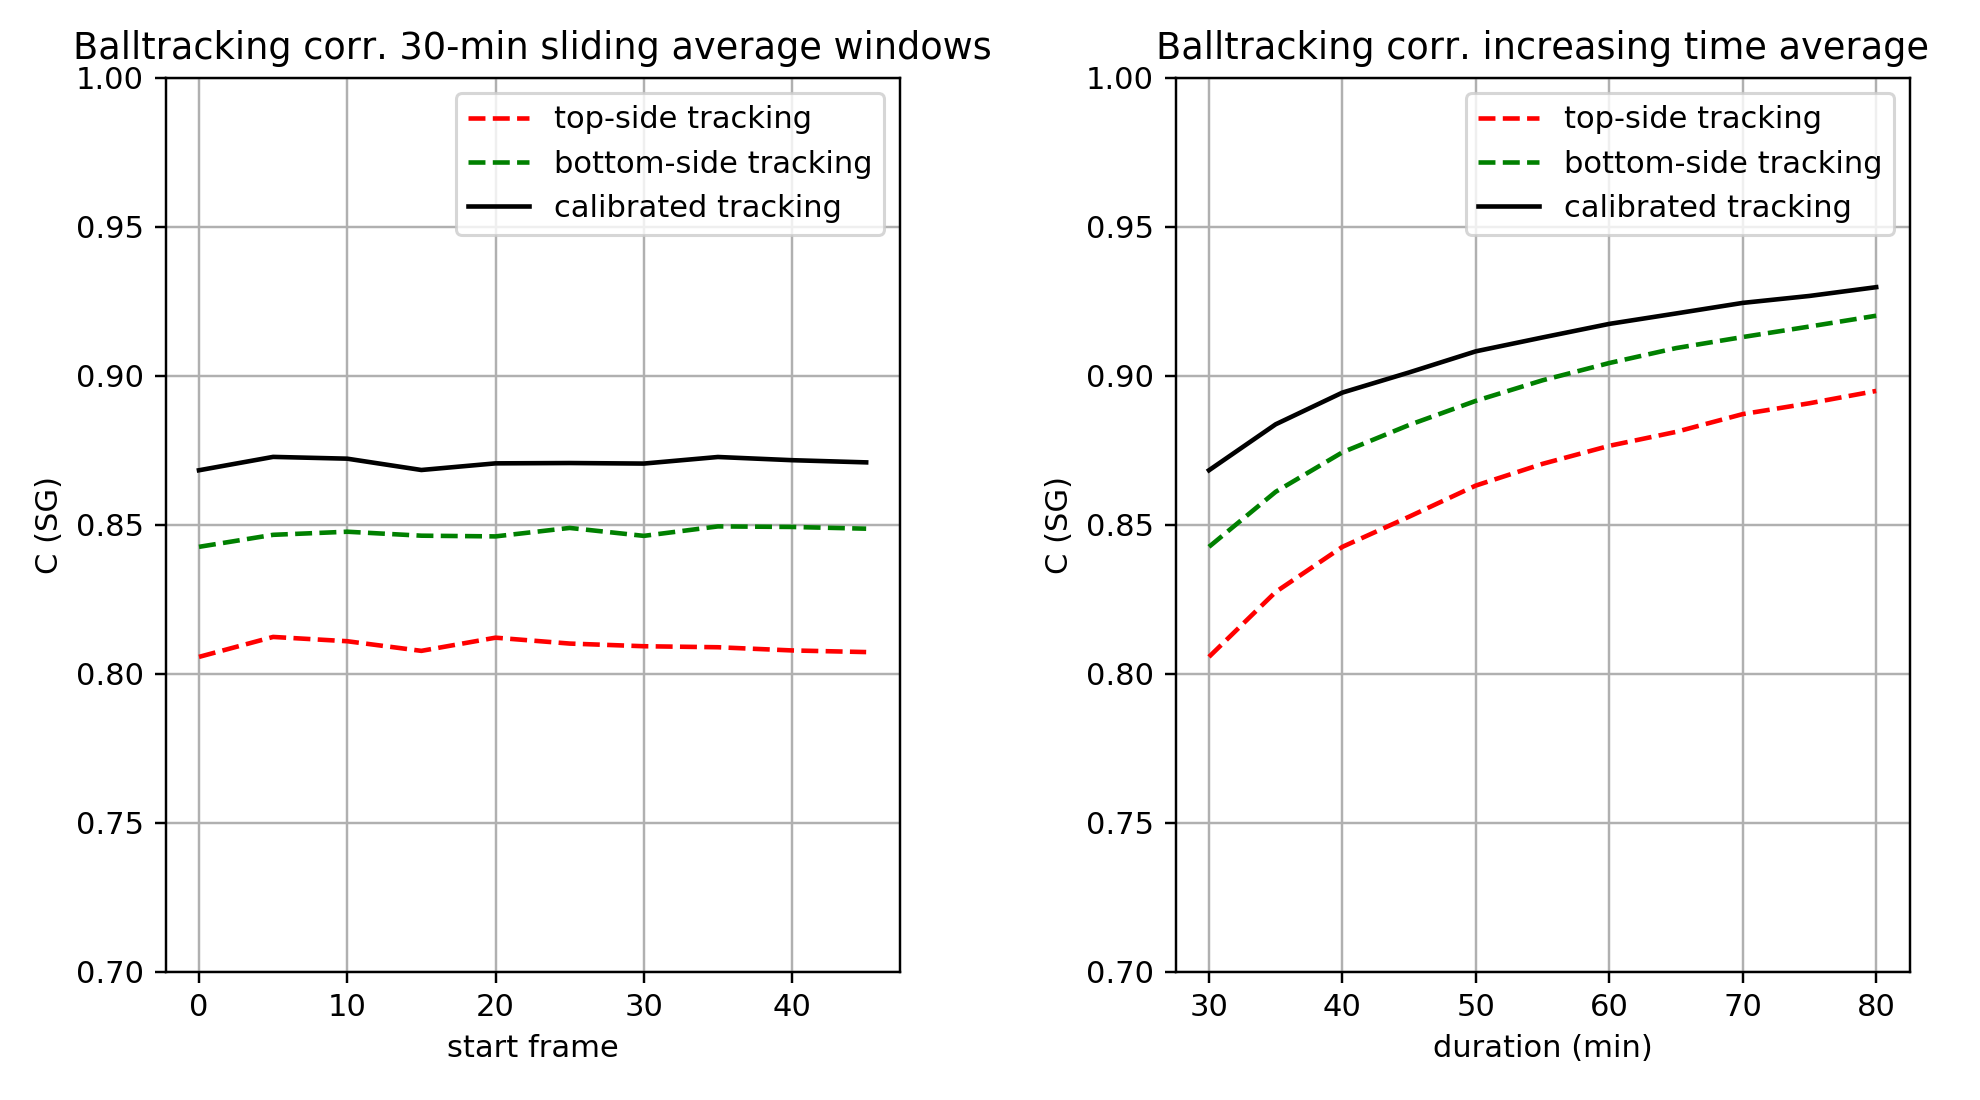

In [36]:
%matplotlib notebook
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.plot(start_frames, c_pearsons_b_top, 'r--', label='top-side tracking')
plt.plot(start_frames, c_pearsons_b_bot, 'g--', label='bottom-side tracking')
plt.plot(start_frames, c_pearsons_b, color='black', label='calibrated tracking')
plt.xlabel('start frame')
plt.ylabel('C (SG)')
plt.grid(True)
plt.legend()
plt.title('Balltracking corr. 30-min sliding average windows')
plt.ylim([0.7, 1.0])

plt.subplot(1,2,2)
plt.plot(twin, c_pearsons_b_top2, 'r--', label='top-side tracking')
plt.plot(twin, c_pearsons_b_bot2, 'g--', label='bottom-side tracking')
plt.plot(twin, c_pearsons_b2, color='black', label='calibrated tracking')
plt.xlabel('duration (min)')
plt.ylabel('C (SG)')
plt.grid(True)
plt.legend()
plt.title('Balltracking corr. increasing time average')
plt.ylim([0.7, 1.0])

plt.tight_layout()

plt.savefig('/Users/rattie/Data/Ben/SteinSDO/optimization_fourier_radius_3px_finer_grid/correlations_fourier_radius_{:d}px_sigma_factor_{:1.2f}.png'.format(fourier_radius, sigma_factor))